In [2]:
import os
import seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

@dataclass
class Request:
    req_id: int
    model_name: str
    prompt_len: int
    output_len: int
    arrival_time: int
    submit_time: int
    prefill_end: int
    end: int


def extract_from_log(logfile):
    stats = {"requests": [], "total": 0}
    with open(logfile, 'r') as f:
        for line in f.readlines():
            if "Name:" in line:
                model = line.split()[-1].strip()
            elif "Summary: Throughput" in line:
                sum_throughput = float(line.split()[6].strip())
                stats["total"] = sum_throughput
            elif "Throughput" in line:
                throughput = float(line.split()[5].strip())
                stats[model] = throughput
            elif "Request" in line:
                request_info = line.strip().split()
                req_id = int(request_info[request_info.index("Request") + 1])
                model_name = request_info[request_info.index("model") + 1]
                prompt_len = int(request_info[request_info.index("prompt") + 1])
                output_len = int(request_info[request_info.index("output") + 1])
                arrival_time = float(request_info[request_info.index("arrival") + 1])
                submit_time = float(request_info[request_info.index("submit") + 1])
                prefill_end = float(request_info[request_info.index("prefill_end") + 1])
                end = float(request_info[request_info.index("end") + 1])
                req = Request(req_id, model_name, prompt_len, output_len, arrival_time, submit_time, prefill_end, end)
                stats["requests"].append(req)
    return stats


def merge_spatial_log(logdir, rates, key_words):
    # names in the format: spatial_7b_bs_rate7.log
    rate_to_files = {}
    for rate in rates:
        rate_to_files[rate] = []
        for name in os.listdir(logdir):
            if "spatial" in name and f"rate{rate}.log" in name and key_words in name:
                rate_to_files[rate].append(name)

    merged_stats = {}
    for rate, files in rate_to_files.items():
        stats = {"requests": []}
        total_requests, total_time = 0, 0
        for file in files:
            model_stats = extract_from_log(os.path.join(logdir, file))

            _ = model_stats.pop("total")
            requests = model_stats.pop("requests")
            stats["requests"].extend(requests)
            for model in sorted(model_stats.keys()):
                throughput = model_stats[model]
                if model not in stats:
                    stats[model] = []
                stats[model] = throughput
                total_time = max(total_time, len(requests) / throughput)
            total_requests += len(requests)

        stats["total"] = total_requests / total_time if total_time > 0 else 0
        merged_stats[rate] = stats
    return merged_stats


muxserve [1.01, 1.92, 2.87, 3.96, 4.93, 5.85, 6.79, 7.67, 8.54, 9.45, 10.26, 10.96, 11.55, 11.98, 12.27, 12.16]
temporal [0.86, 1.44, 2.86, 2.79, 2.35, 4.37, 6.47, 0, 0, 0, 0, 0, 8.85, 8.35, 7.45, 0]
spatial [0.02, 1.95975, 2.51, 3.7185, 2.03, 5.065, 5.3389, 5.349049999999999, 5.450550000000001, 5.28815, 5.450550000000001, 5.48033, 5.409949999999999, 4.969640000000001, 4.84892, 0.04]


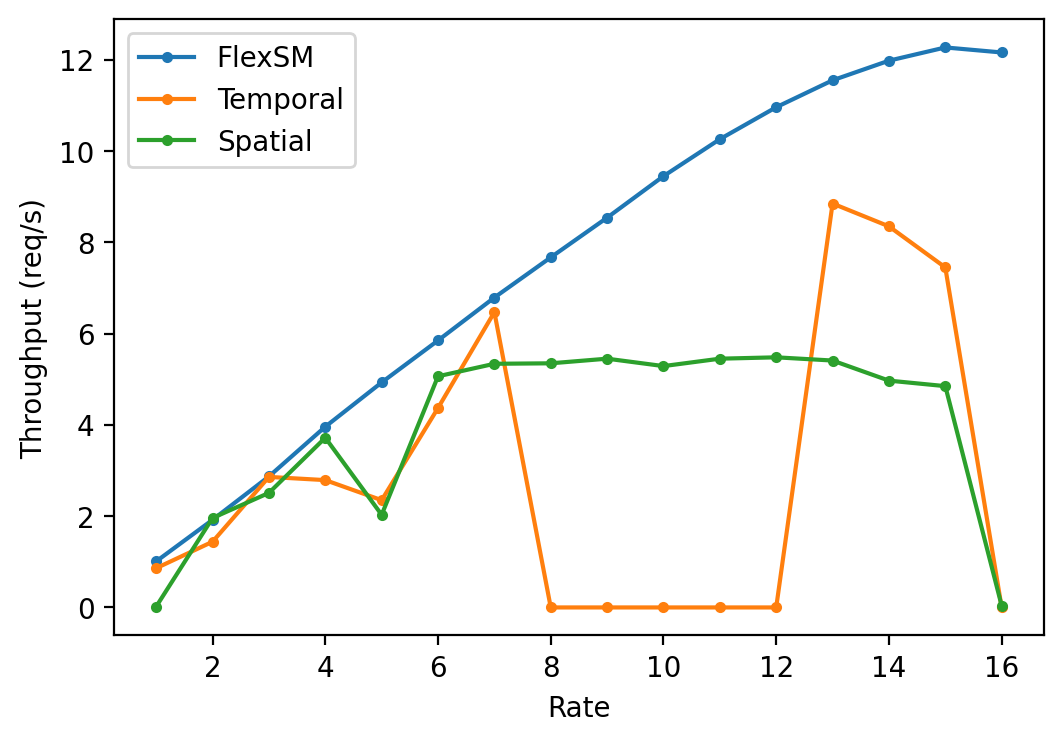

In [7]:
basedir = "/mnt/afs/jfduan/LLMInfer/MuxServe/log/bench_7b_13b_30b_uneven"

# rates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]
rates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
tpts = {
    "muxserve": [0] * len(rates),
    "temporal": [0] * len(rates),
    "spatial": [0] * len(rates),
}
name_map = {
    "muxserve": "MuxServe",
    "temporal": "Temporal",
    "spatial": "Spatial",
}

key_words = "7b_13b_30b_bs256"
for logdir in [f"{basedir}/temporal", f"{basedir}/muxserve_7b9040"]:
    for name in os.listdir(f"{logdir}"):
        if key_words in name:
            approach = name.split("_")[0]
            rate = int(name.split(".")[0].split("rate")[-1])
            stats = extract_from_log(os.path.join(logdir, name))
            if rate not in rates:
                continue
            tpts[approach][rates.index(rate)] = stats.get("total", 0)

key_words = "_bs128"
spatial_stats = merge_spatial_log(f"{basedir}/spatial", rates, key_words)
for key, value in spatial_stats.items():
    if key == "requests":
        continue
    tpts["spatial"][rates.index(int(key))] = value["total"]

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
for approach in tpts:
    # if approach != "muxserve":
    #     continue
    ax.plot(rates, tpts[approach], label=name_map[approach], marker='.')
    print(approach, tpts[approach])
ax.set_xlabel("Rate")
ax.set_ylabel("Throughput (req/s)")
ax.legend()
# plt.savefig("muxserve.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

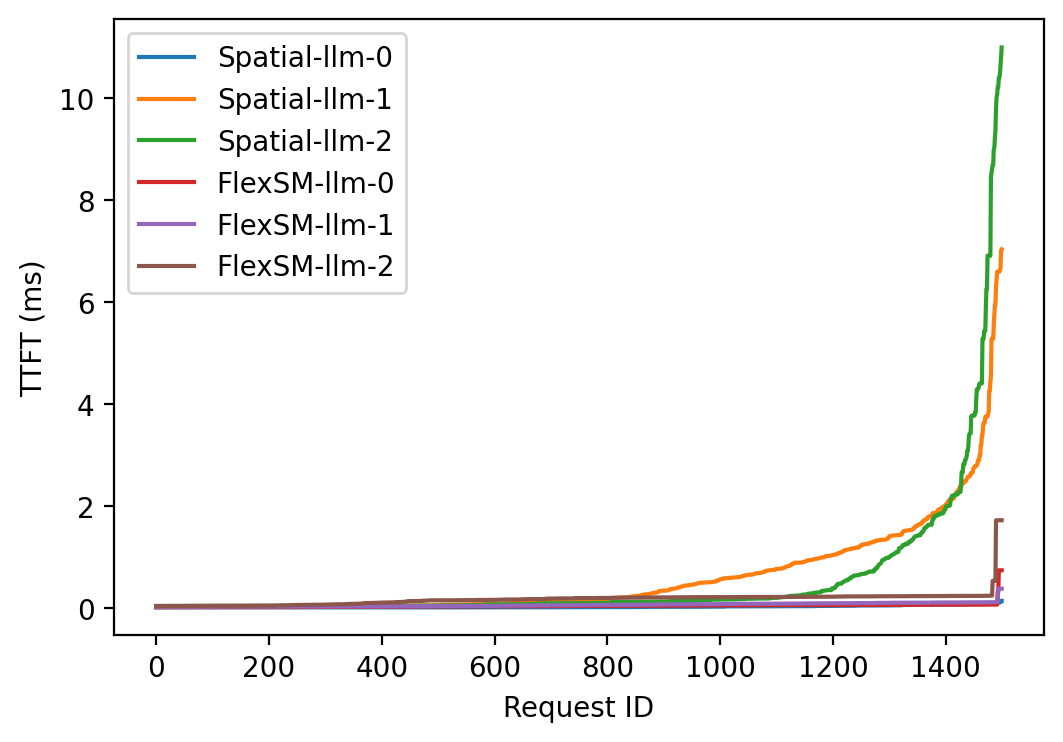

In [3]:
# Serve 7b,13b,30b models together
spatial_requests = spatial_stats[7]["requests"]
muxserve_requests = extract_from_log(f"{basedir}/muxserve_7b9040/muxserve_7b_13b_30b_bs128_rate7.log")["requests"]

fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
for (approach, requests) in [("Spatial", spatial_requests), ("MuxServe", muxserve_requests)]:
    for model in ["llm-0", "llm-1", "llm-2"]:
        TTFTs = []
        for req in requests:
            if req.model_name == model:
                TTFTs.append(req.prefill_end - req.submit_time)
        # plot density curve of TTFTs
        TTFTs.sort()
        ax.plot(list(range(len(TTFTs))), TTFTs, label=f"{approach}-{model}")
ax.set_xlabel("Request ID")
ax.set_ylabel("TTFT (ms)")
ax.legend()
# plt.savefig("muxserve_ttft.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

p=1, num_skip=0, extra_time=0.000, mean_lat: 0.2762, end_time: 43.689
p=2, num_skip=0, extra_time=0.000, mean_lat: 0.2520, end_time: 23.423
p=4, num_skip=33, extra_time=32.646, mean_lat: 0.2395, end_time: 36.769
p=8, num_skip=0, extra_time=0.000, mean_lat: 0.2323, end_time: 30.83


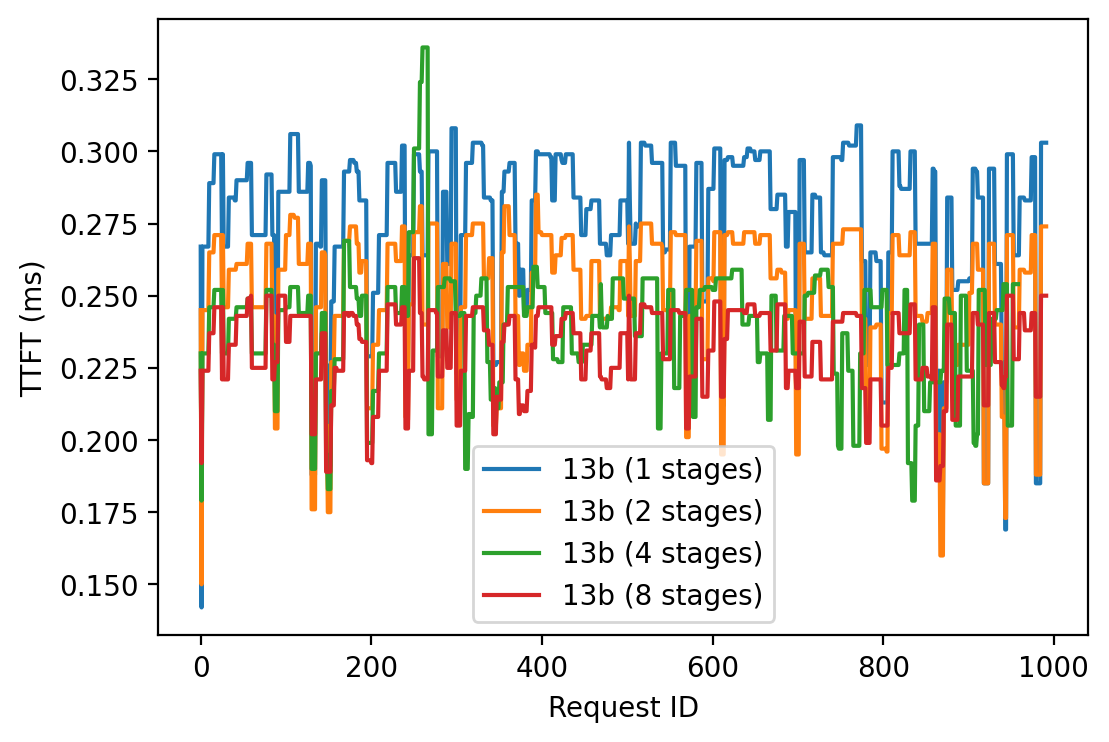

In [18]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
model = "13b"
for p in [1, 2, 4, 8]:
    # logfile = f"{basedir}/../muxserve_13b_p{p}_rate10.log"
    logfile = f"{basedir}/../muxserve_13b_prefill_s{p}.log"
    stats = extract_from_log(logfile)
    requests = stats["requests"]
    TTFTs = []
    num_skip, extra_time, end_time = 0, 0, 0
    for req in requests:
        end_time = max(end_time, req.end)
        if req.req_id in [0, 2, 6, 14, 30, 62, 126, 254]:
            continue
        if req.prefill_end - req.submit_time > 0.5:
            num_skip += 1
            extra_time += req.prefill_end - req.submit_time - 0.26
            continue
        TTFTs.append(req.prefill_end - req.submit_time)
    # plot density curve of TTFTs
    # TTFTs.sort()
    ax.plot(list(range(len(TTFTs))), TTFTs, label=f"{model} ({p} stages)")
    print(
        f"p={p}, num_skip={num_skip}, extra_time={extra_time:.3f}, mean_lat: {np.mean(TTFTs):.4f}, end_time: {end_time}"
    )
ax.set_xlabel("Request ID")
ax.set_ylabel("TTFT (ms)")
ax.legend()
# plt.savefig("muxserve_ttft.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [6]:
# check actual request arrival rate
import dataclasses
import json
from muxserve.muxsched.workload_utils import Workload

workload_file = "/mnt/afs/jfduan/LLMInfer/MuxServe/examples/workloads/sharegpt_uneven_n3_max{}.json"

replace_with_base_requests = False
baseworkload = Workload.from_workload_file(workload_file.format(1))
for req in baseworkload.requests:
    req.data = (req.data[0].tolist(), req.data[1], req.data[2])
base_llm0_wk = baseworkload.split_by_model("llm-0")
base_llm1_wk = baseworkload.split_by_model("llm-1")
base_llm2_wk = baseworkload.split_by_model("llm-2")

for rate in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    workload = Workload.from_workload_file(workload_file.format(rate))

    # replace workloads with the same requests
    if replace_with_base_requests:
        workload_info = workload.workload_infos
        llm0_wk = workload.split_by_model("llm-0")
        llm1_wk = workload.split_by_model("llm-1")
        llm2_wk = workload.split_by_model("llm-2")
        llm0_wk.requests = base_llm0_wk.requests[:len(llm0_wk.requests)]
        llm1_wk.requests = base_llm1_wk.requests[:len(llm1_wk.requests)]
        llm2_wk.requests = base_llm2_wk.requests[:len(llm2_wk.requests)]

        w = Workload.merge(llm0_wk, llm1_wk, llm2_wk)
        workload_json = {
            "info": workload_info,
            "arrivals": w.arrivals.tolist(),
            "requests": [dataclasses.asdict(r) for r in w.requests]
        }
        workload.workload_infos["rates"]
        workload_json["info"]["rates"] = [['llm-0', rate], ['llm-1', rate],
                                         ['llm-2', rate]]
        output_file = workload_file.format(rate)

        print(f"Save workload to {output_file}")
        with open(output_file, "w") as f:
            json.dump(workload_json, f)

    requests, arrivals = {}, {}
    max_ts = {}
    for ts, req in zip(workload.arrivals, workload.requests):
        if req.model_name not in requests:
            requests[req.model_name] = []
            arrivals[req.model_name] = []
        requests[req.model_name].append(req)
        arrivals[req.model_name].append(ts)
        max_ts[req.model_name] = ts
    for model in sorted(requests.keys()):
        avg_prompt_len = np.mean([req.data[1] for req in requests[model]])
        avg_output_len = np.mean([req.data[2] for req in requests[model]])
        print(
            f"rate: {rate}, model: {model}, "
            f"rate: {len(requests[model]) / max_ts[model]:.3f}, "
            f"Avg prompt len: {avg_prompt_len:.3f}, "
            f"Avg output len: {avg_output_len:.3f}"
        )

Save workload to /mnt/afs/jfduan/LLMInfer/MuxServe/examples/workloads/sharegpt_uneven_n3_max2.json
rate: 2, model: llm-0, rate: 1.993, Avg prompt len: 243.274, Avg output len: 236.831
rate: 2, model: llm-1, rate: 0.014, Avg prompt len: 413.700, Avg output len: 226.100
rate: 2, model: llm-2, rate: 0.007, Avg prompt len: 155.400, Avg output len: 336.800
Save workload to /mnt/afs/jfduan/LLMInfer/MuxServe/examples/workloads/sharegpt_uneven_n3_max3.json
rate: 3, model: llm-0, rate: 2.989, Avg prompt len: 247.268, Avg output len: 227.522
rate: 3, model: llm-1, rate: 0.029, Avg prompt len: 242.444, Avg output len: 247.667
rate: 3, model: llm-2, rate: 0.012, Avg prompt len: 222.000, Avg output len: 212.250
Save workload to /mnt/afs/jfduan/LLMInfer/MuxServe/examples/workloads/sharegpt_uneven_n3_max4.json
rate: 4, model: llm-0, rate: 3.986, Avg prompt len: 233.367, Avg output len: 246.449
rate: 4, model: llm-1, rate: 0.029, Avg prompt len: 207.000, Avg output len: 243.500
rate: 4, model: llm-2, 